# Making games with TextWorld

## Method 1 - Random generation
This method is the simplest and the fastest. It makes use of the `tw-make` script shipped with TextWorld. The following command will generate a text-based game with 1 location (`--world-size 1`), minimum of 10 interactable objects (`--nb-objects 10`), a quest that requires a minimum of 5 commands to be solved (`--quest-length 5`), named entities will have adjective(s) (`--include-adj`). Using a fixed seed (`--seed 1234`) we ensure the game generation is reproducible. The generated game (`demo.ulx`) will be saved in the folder `tw_games` (`--output ./tw_games/demo.ulx`) and any previously existing files will be overwritten (`-f`).

In [1]:
!tw-make custom --world-size 1 --nb-objects 10 --quest-length 5 --include-adj --seed 1234 -f --output ./tw_games/demo.ulx

Global seed: 1234
Game generated: ./tw_games/demo.ulx


### Testing the game
Once the game generated, we can easily try it out either by using the associated walkthrough (`WalkthroughAgent`) or the standard way (`HumanAgent`). 

In [2]:
import textworld
# Play the game using the walkthrough.
agent = textworld.agents.WalkthroughAgent()
# Uncomment the next line to try the game yourself.
# agent = textworld.agents.HumanAgent()
textworld.play("./tw_games/demo.ulx", agent)




You are now playing a life changing round of TextWorld! Here is how to play!
Your first objective is to look and see that the nice TextWorld style locker is
opened. And then, retrieve the steel type G key from the nice TextWorld style
locker within the messy attic. If you can get your hands on the steel type G
key, insert the steel type G key into the nice type G chest's lock to unlock it.
Then, make it so that the nice type G chest in the messy attic is open. After
that, pick up the brass keycard from the nice type G chest in the messy attic.
Once that's all handled, you can stop!

-= Messy Attic =-
You find yourself in an attic. A messy one.

You see a locked type G chest. You lean against the wall, inadvertently pressing
a secret button. The wall opens up to reveal a TextWorld style locker. You make
out a nice American limited edition safe. The nice American limited edition safe
contains a contemporary pair of pants. You see a chest. Classic TextWorld. You
can see a splintery wor

Feel free to play around with the options of `tw-make` and try out the resulting games.

**Notes:** Setting the value for `--world-size` and `--quest-length` too high (e.g. `--world-size 10 --quest-length 15`) might result in a long generation time.

## Method 2 - Handcrafting
This method is used when more control over the generation is needed. It makes use of the TextWorld's API, more specically the `GameMaker` class (still a prototype). In this section we will make a game consisting of two rooms and where the goal is to place an object from the player's inventory inside a container located in the other room.

**Notes:** To be able to re-run any cell of this section independently, each cell starts by copying the whole `GameMaker` object (which is a stateful object). To propagate changes made in an earlier cell, all cells coming after it must be run again.

In [3]:
import copy
import textworld

# Make the generation process reproducible.
textworld.g_rng.set_seed(20181204)  # Global random generator for TextWorld.

# GameMaker object for handcrafting text-based games.
M = textworld.GameMaker()

#### First, define the layout of the world.

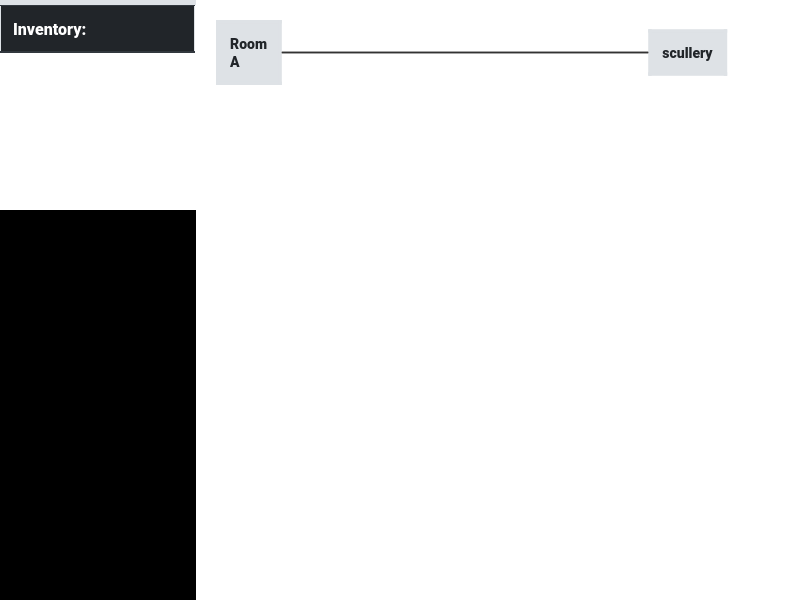

In [4]:
M1 = copy.deepcopy(M)

roomA = M1.new_room("Room A")  # Create a first room with the name "Room A".
roomB = M1.new_room()          # Create a second room with a random name.

# Connect the two rooms using cardinal directions: west, east, south, and north.
corridor = M1.connect(roomA.east, roomB.west)
# Only reciprocal connections are supported at the moment,
# i.e. north-south, south-north, east-west or west-east.
#corridor = M1.connect(roomA.east, roomB.north)  # This would fail.

M1.render()  # Render the current state of the game. 

#### Place the player somewhere.

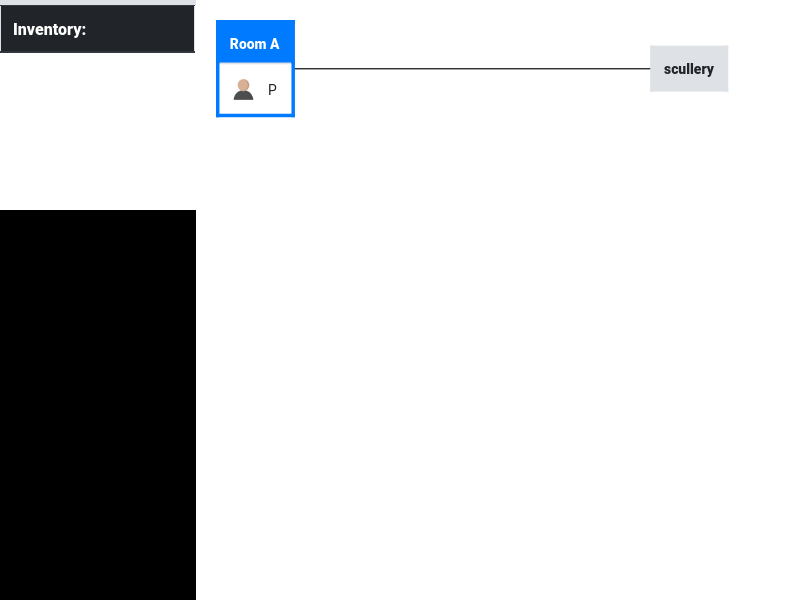

In [5]:
M2 = copy.deepcopy(M1)
M2.set_player(roomA)
M2.render()

#### Add two objects to Room A.

TextWorld comes with a basic Knowledge Base containing the following object types:

type | name | description
--------|-----|------------
'r' | room | can contain objects, can be connected with other rooms
'd' | door | (un)lockable, openable/closable
'c' | container | can hold objects, (un)lockable, openable/closable
's' | supporter | can hold objects
'o' | portable object | can be carried by the player
'k' | key | subtype of portable object, match a door or container's lock
'f' | food | subtype of portable object, can be eaten if edible

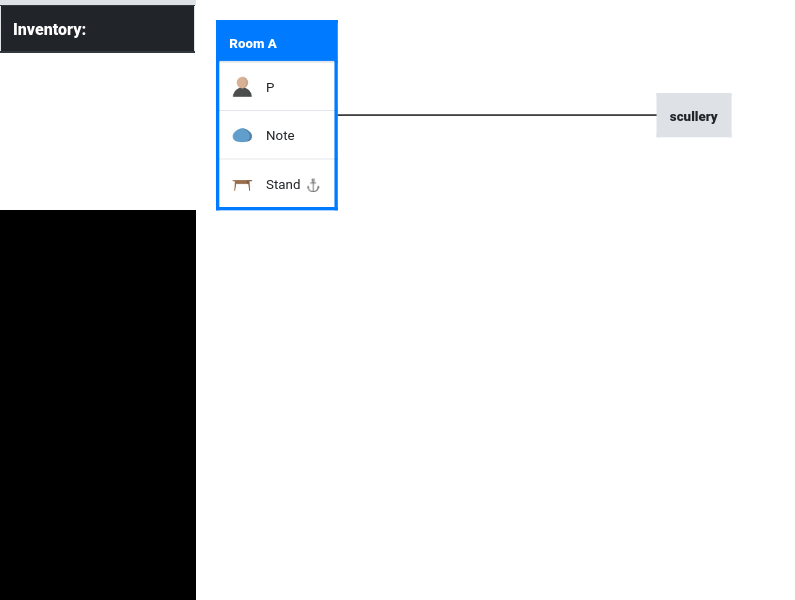

In [6]:
M3 = copy.deepcopy(M2)

# Let's create a note (portable object) and a random supporter (fixed in place).
note = M3.new(type='o', name="note")  # Provide the type (see table above) and the name of the object.
note.desc = "Bravo! You can read."    # Text to display when issuing command "examine note". 
supporter = M3.new(type='s')  # When not provided, the name is automatically generated.

# Add the supporter and the note to roomA.
M3.add(roomA, supporter)  # Supporters are fixed in place.
M3.add(roomA, note)       # When added directly to a room, portable objects are put on the floor.

M3.render()

#### Let's add a locked door between the two rooms.

TextWorld's basic Knowledge Base understands the following useful facts:

fact | description
----------------|------------
__match__(key, container/door) | The `key` matches the `container/door`'s lock.
__open__(container/door) | The `container/door` is open.
__closed__(container/door) | The `container/door` is closed.
__locked__(container/door) | The `container/door` is locked.
__edible__(food) | The `food` is edible.

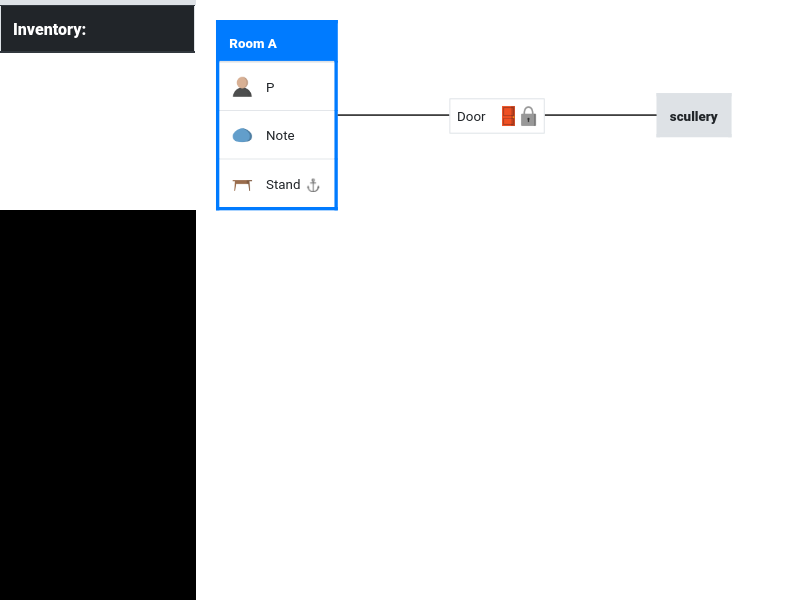

In [7]:
M4 = copy.deepcopy(M3)
# To add a door, we need to tell on which connection (returned by `M.connect`) to place it.
door = M4.new_door(corridor, name="door")  # Door and room have their own "new" method, no need to provide the type.
M4.add_fact("locked", door)  # Add a fact about the door, i.e. it is locked.
M4.render()

#### Create a key object that be used to unlock the door and place it on the supporter object.

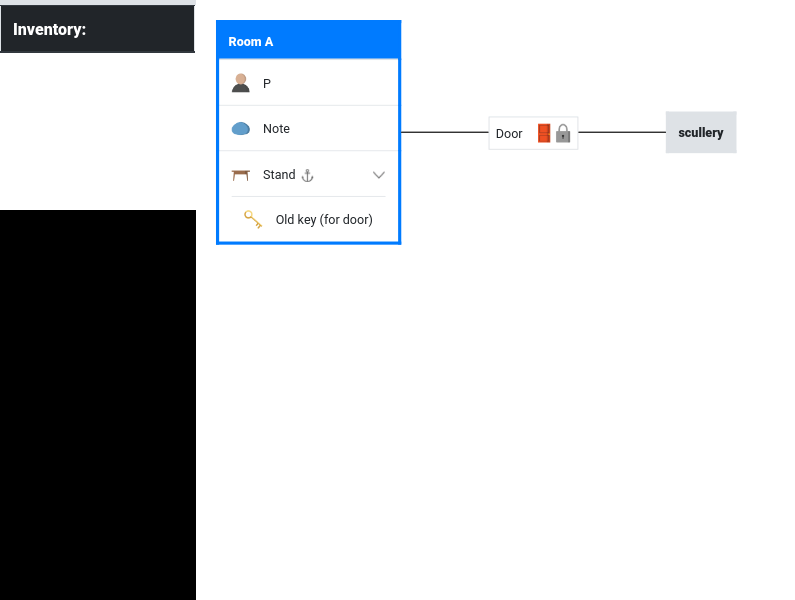

In [8]:
M5 = copy.deepcopy(M4)
key = M5.new(type="k", name="old key")  # Create a 'k' (i.e. key) object. 
M5.add_fact("match", key, door)  # Tell the game 'old key' is matching the door's lock
M5.add(supporter, key)  # Add the 'old key' on the supporter.
M5.render()

#### Create the object carried by the player and the container (initially closed).

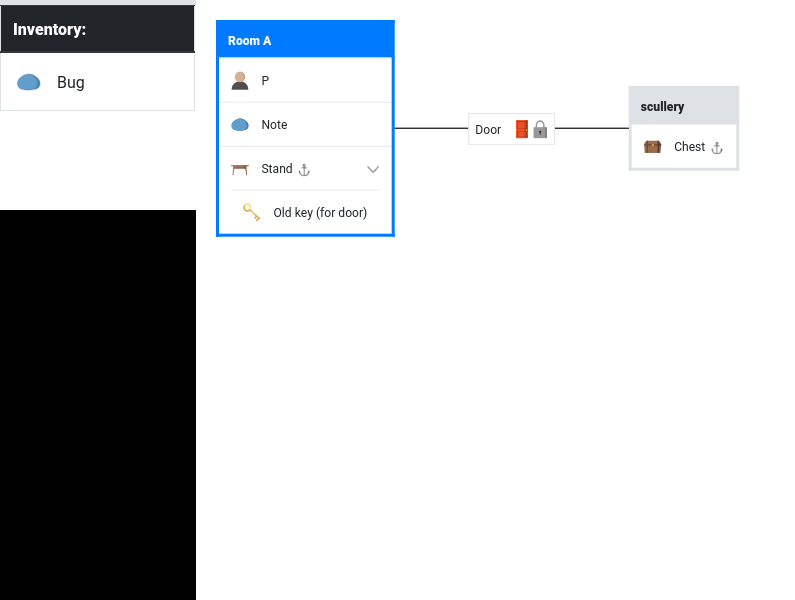

In [9]:
M6 = copy.deepcopy(M5)

obj = M6.new(type='o')    # New portable object with a randomly generated name.
M6.add(M6.inventory, obj) # Add the object to the player's inventory.

container = M6.new(type='c')      # Creating a container with a randomly generated name
M6.add_fact("closed", container)  # Set the state of the container to be 'closed'.
M6.add(roomB, container)  # Place the container in Room B

M6.render()

### Adding a quest to the game
We want the objective of the game to be the following: place the carried object into the container of the second room.

#### 1. Using a predefined sequence of commands

In [10]:
M7 = copy.deepcopy(M6)

# Given the initial game state (as seen with M6.render()), one can infer the sequences
# of commands that needs to be taken.
commands = ["take old key from stand", "unlock door with old key", 
            "open door", "go east", "open chest", "insert bug into chest"]
quest = M7.set_quest_from_commands(commands)

# The returned `quest` object has a generated text description of the quest.
print(quest.desc)

Welcome to another life changing round of TextWorld! Here is how to play! First, it would be fantastic if you could recover the old key from the stand within the Room A. After that, insert the old key into the door within the Room A's lock to unlock it. And then, ensure that the door inside the Room A is open. After that, go to the east. And then, doublecheck that the chest is open. And then, you can deposit the bug inside the chest inside the scullery. Once that's all handled, you can stop!


#### 2. By recording the commands interactively 

In [ ]:
M7 = copy.deepcopy(M6)

# Type all commands needed to place the object carried initially into 
# the container of the second room. To end recording, either type 
# `quit` or interrupt the kernel (the stop button above).
quest = M7.record_quest()
print(quest.desc)

#### 3. Randomly add one

take old key from stand > unlock door with old key > open door > go east > insert old key into refrigerator
take old key from stand > unlock door with old key > open door > go east > drop old key
take old key from stand > unlock door with old key > open door > go east > put old key on counter
open safe > insert cushion into safe > insert worm into safe > close safe > lock safe with key
take American limited edition latchkey > unlock American limited edition box with American limited edition latchkey > open American limited edition box > insert bug into American limited edition box > close American limited edition box > lock American limited edition box with American limited edition latchkey
take old key from stand > unlock door with old key > open door > go east > insert bug into refrigerator
open American limited edition locker > take burger from American limited edition locker > put burger on stand > insert American limited edition keycard into American limited edition locker > close

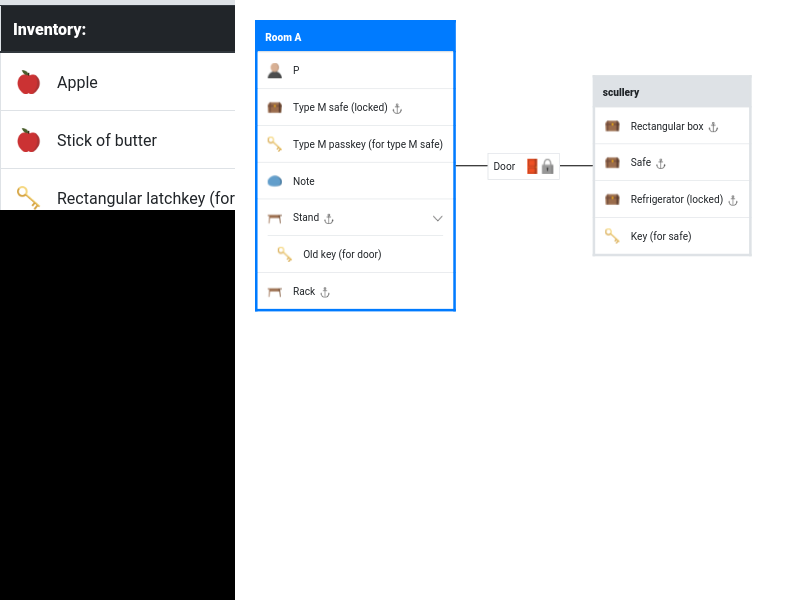

In [12]:
for i in range(10):
    M8 = copy.deepcopy(M6)
    M8.add_distractors(10)  # Add 10 random objects scattered throughout the world.
    quest = M8.add_random_quest(max_length=5)
    print(" > ".join(quest.commands))

print("\n" + quest.desc)
M8.render()

## Handcrafting your game
For convenience, the code for making the above game was copied the following cell. Feel free to modify it as you please. Here are some suggestions of what you could try:

- Adding a new room north of `roomB`;
- Locking the container in `roomB` and put its matching key on the floor of `roomA`;
- Hiding a food object in the container of `roomB` and build a quest for eating it.

In [ ]:
import textworld

# Make the generation process reproducible.
textworld.g_rng.set_seed(20181204)

# GameMaker object for handcrafting text-based games.
M = textworld.GameMaker()

# <--- Designing the game --->

roomA = M.new_room("Room A")  # Create a first room with the name "Room A".
roomB = M.new_room()          # Create a second room with a random name.

# Connect the two rooms using cardinal directions: west, east, south, and north.
corridor = M.connect(roomA.east, roomB.west)
# Only reciprocal connections are supported at the moment,
# i.e. north-south, south-north, east-west or west-east.
#corridor = M.connect(roomA.east, roomB.north)  # This would fail.

M.set_player(roomA)

# Let's create a note (portable object) and a random supporter (fixed in place).
note = M.new(type='o', name="note")  # Provide the type (see table above) and the name of the object.
note.desc = "Bravo! You can read."    # Text to display when issuing command "examine note". 
supporter = M.new(type='s')  # When not provided, the name is automatically generated.

# Add the supporter and the note to roomA.
M.add(roomA, supporter)  # Supporters are fixed in place.
M.add(roomA, note)       # When added directly to a room, portable objects are put on the floor.

# To add a door, we need to tell on which connection (returned by `M.connect`) to place it.
door = M.new_door(corridor, name="door")  # Door and room have their own "new" method, no need to provide the type.
M.add_fact("locked", door)  # Add a fact about the door, i.e. it is locked.

key = M.new(type="k", name="old key")  # Create a 'k' (i.e. key) object. 
M.add_fact("match", key, door)  # Tell the game 'old key' is matching the door's lock
M.add(supporter, key)  # Add the 'old key' on the supporter.

obj = M.new(type='o')    # New portable object with a randomly generated name.
M.add(M.inventory, obj) # Add the object to the player's inventory.

container = M.new(type='c')      # Creating a container with a randomly generated name
M.add_fact("closed", container)  # Set the state of the container to be 'closed'.
M.add(roomB, container)  # Place the container in Room B

M.render()

# Uncomment the following lines to record a quest.
# quest = M.record_quest()
# print(" > ".join(quest.commands))
# print("\n" + quest.desc)
M.test()

# Troubleshooting
- `FailedConstraintsError`: One the constraints has failed. You need to resolve the issue before being able to compile the game. The most common issues:
    - Two objects cannot have the exact same name. Names can be composed of multiple words.
    - A same objects was added twice to a container, supporter, room or inventory.
- `ValueError: Could not determine status '' of container/door ...`: You have to provide the status (a fact) of the door/container, i.e. 'open', 'closed' or 'locked'.